In [33]:
import logging
import ConfigParser
import csv
import functools
import getpass
import koji
import datetime
import time
from requests.exceptions import ConnectionError
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression

class Brew():

    def __init__(self):
        self.client = koji.ClientSession('http://brewhub.engineering.redhat.com/brewhub')
    
    def retry(timeout=240, interval=60, wait_on=Exception):
        """ A decorator that allows to retry a section of code...
        ...until success or timeout.
        """
        def wrapper(function):
            @functools.wraps(function)
            def inner(*args, **kwargs):
                start = time.time()
                while True:
                    if (time.time() - start) >= timeout:
                        raise  # This re-raises the last exception.
                    try:
                        return function(*args, **kwargs)
                    except wait_on as e:
                        print("Exception %r raised from %r.  Retry in %rs" % (
                            e, function, interval))
                        time.sleep(interval)
            return inner
        return wrapper

    def iterator(self, start_date, end_date):
        current_date = start_date
        delta = datetime.timedelta(days=1)
        while current_date < end_date:
            yield current_date
            current_date += delta
            
    @retry(wait_on=ConnectionError)
    def find_data(self):
        # fetch builds from Teiid
        docs = []
        start_date = datetime.datetime.strptime(
                '2015-01-01', '%Y-%m-%d').date()
        end_date = datetime.date.today()
        previous_date = start_date
        count = 0
        for date in self.iterator(start_date, end_date):
            builds = self.client.listBuilds(
                    completeAfter=str(previous_date), completeBefore=str(date))
            docs.extend(builds)
            previous_date = date
            count += 1
            if count%5 == 0:
                time.sleep(1)

        return docs
    
    def copy_data_in_csv(self, docs):
        # This is just faster in terms of retrieval. The calculation of diff and removal of None 
        # would be easier in dataframes.
        print len(docs)
        the_file = open("metric_data.csv", "w")
        writer = csv.DictWriter(the_file, docs[0].keys())
        writer.writeheader()
        writer.writerows(docs)
        the_file.close()        
    
br = Brew()
docs = br.find_data()
br.copy_data_in_csv(docs)


169971


In [3]:
# Read data from csv to a dataframe
import pandas as pd
data_df = pd.read_csv("metric_data.csv")
# data_df

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Calculate the waiting time of a build
print "Total builds in data_df: ", len(data_df)
data_df['waiting_time(seconds)'] = (data_df.creation_ts - data_df.start_ts)
diff_df = data_df[['creation_ts','start_ts','waiting_time(seconds)']]

null_wait_data_df = data_df[pd.isnull(data_df['waiting_time(seconds)'])]
data_df = data_df[pd.notnull(data_df['waiting_time(seconds)'])]
print "Builds having NaN wait times: ", len(null_wait_data_df)
print "Builds left after removing NaN wait times: ", len(data_df)
data_df

Total builds in data_df:  169971
Builds having NaN wait times:  60615
Builds left after removing NaN wait times:  109356


,package_name,extra,creation_time,completion_time,package_id,build_id,state,source,epoch,version,...,start_time,creation_event_id,start_ts,volume_id,creation_ts,name,task_id,volume_name,release,waiting_time(seconds)
60615,openshift-enterprise-recycler-docker,NaN,2015-12-01 16:34:09.406421,2015-12-01 16:51:36.424373,54855,468704,2,NaN,0.0,v3.1.0.4,...,2015-12-01 16:34:09.406421,12297080,1.448988e+09,0,1.448988e+09,openshift-enterprise-recycler-docker,10177434.0,DEFAULT,2,0.00000
60616,logging-auth-proxy-docker,NaN,2015-12-01 16:46:47.387424,2015-12-01 17:00:07.559909,54387,468707,2,NaN,0.0,3.1.0,...,2015-12-01 16:46:47.387424,12297116,1.448988e+09,0,1.448988e+09,logging-auth-proxy-docker,10177684.0,DEFAULT,3,0.00000
60617,eap7-wildfly,NaN,2015-12-01 16:57:59.887151,2015-12-01 17:03:19.891017,50840,468711,2,NaN,0.0,10.0.0,...,2015-12-01 16:57:59.887151,12297153,1.448989e+09,0,1.448989e+09,eap7-wildfly,10177751.0,DEFAULT,69.CR6_redhat_1.1.ep7.el7,0.00000
60618,logging-deployment-docker,NaN,2015-12-01 16:41:07.14553,2015-12-01 17:07:40.348823,54386,468706,2,NaN,0.0,3.1.0,...,2015-12-01 16:41:07.14553,12297107,1.448988e+09,0,1.448988e+09,logging-deployment-docker,10177591.0,DEFAULT,3,0.00000
60619,logging-fluentd-docker,NaN,2015-12-01 16:53:30.444788,2015-12-01 17:09:19.738653,54384,468710,2,NaN,0.0,3.1.0,...,2015-12-01 16:53:30.444788,12297144,1.448989e+09,0,1.448989e+09,logging-fluentd-docker,10177742.0,DEFAULT,5,0.00000
60620,logging-elasticsearch-docker,NaN,2015-12-01 16:47:32.398697,2015-12-01 17:10:11.231555,54385,468708,2,NaN,0.0,3.1.0,...,2015-12-01 16:47:32.398697,12297120,1.448988e+09,0,1.448988e+09,logging-elasticsearch-docker,10177701.0,DEFAULT,3,0.00000
60621,logging-kibana-docker,NaN,2015-12-01 16:53:22.725258,2015-12-01 17:10:12.460644,54383,468709,2,NaN,0.0,3.1.0,...,2015-12-01 16:53:22.725258,12297143,1.448989e+09,0,1.448989e+09,logging-kibana-docker,10177725.0,DEFAULT,3,0.00000
60622,eap7-wildfly,NaN,2015-12-01 17:10:41.573022,2015-12-01 17:15:48.431246,50840,468712,2,NaN,0.0,10.0.0,...,2015-12-01 17:10:41.573022,12297213,1.448990e+09,0,1.448990e+09,eap7-wildfly,10177819.0,DEFAULT,69.CR6_redhat_1.1.ep7.el6,0.00000
60623,com.sun.xml.bind.mvn-jaxb-parent,NaN,2015-12-01 17:51:09.753085,2015-12-01 17:51:10.701959,48730,468713,1,NaN,NaN,2.2.11.redhat_3,...,2015-12-01 17:51:09.753085,12297315,1.448992e+09,0,1.448992e+09,com.sun.xml.bind.mvn-jaxb-parent,10178028.0,DEFAULT,1,0.00000
60624,Red_Hat_Enterprise_Linux-System-Level_Authenti...,NaN,2015-12-01 17:52:13.013825,2015-12-01 18:09:06.437308,55123,468714,1,NaN,NaN,7.0,...,2015-12-01 17:52:13.013825,12297323,1.448992e+09,0,1.448992e+09,Red_Hat_Enterprise_Linux-System-Level_Authenti...,10178085.0,DEFAULT,6.2.el6eng,0.00000


In [5]:
# Separate out the docker and non-docker builds because it looks like
# only docker builds have a lag
docker_builds = []
non_docker_builds = []
docker_builds = data_df[pd.notnull(data_df['extra'])].values.tolist()
non_docker_builds = data_df[pd.isnull(data_df['extra'])].values.tolist()
print "Docker builds (total): ",len(docker_builds)
print "Non-Docker builds (total): ", len(non_docker_builds)

Docker builds (total):  18494
Non-Docker builds (total):  90862


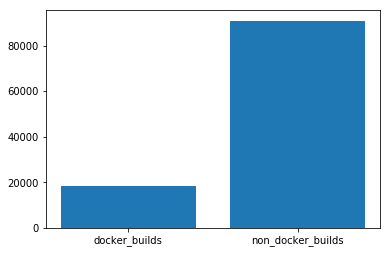

In [6]:
# Plotting the number of docker and non-docker builds
import numpy as np
import matplotlib.pyplot as plt
import datetime

D = {'docker_builds':len(docker_builds), 'non_docker_builds':len(non_docker_builds)}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()


In [7]:
# Builds having negative wait time
mystery_machine = []
for i in data_df.values.tolist():
    if (i[len(i)-1] == 0):
        continue
    elif(i[len(i)-1] > 0):
        continue
    else:
        mystery_machine.append(i)
print mystery_machine[0]

print "Number of builds having NEGATIVE wait time: ", len(mystery_machine)

['osbs-buildroot-docker', "{'image': {}}", '2016-05-31 08:50:39.278758', '2016-05-31 08:50:12', 50072, 497336, 2, 'git://pkgs.devel.redhat.com/rpms/osbs-buildroot-docker#2222014aef343ed4ab6a24439222e5e070b2af58', nan, '1.0', 1464684612.0, 3436, 'osbs', 'osbs-buildroot-docker-1.0-1.0.twaugh.31', '2016-05-31 12:40:13', 13306028, 1464698413.0, 0, 1464684639.27876, 'osbs-buildroot-docker', nan, 'DEFAULT', '1.0.twaugh.31', -13773.72124004364]
Number of builds having NEGATIVE wait time:  34


In [8]:
# Builds having waiting time >0 and ==0 and confirming that only
# docker builds have non-zero wait times.

print 'Total builds present after filtering those with NaN: ', len(data_df)

builds_nonzero_wait = data_df[data_df['waiting_time(seconds)']>0]
print "Total builds with non-zero wait time:                ", len(builds_nonzero_wait)
docker_builds_nonzero_wait = builds_nonzero_wait[pd.notnull(builds_nonzero_wait['extra'])].values.tolist()


builds_zero_wait = data_df[data_df['waiting_time(seconds)'] == 0.000]
print "Total builds with zero wait time:                    ", len(builds_zero_wait)
non_docker_builds_zero_wait = builds_zero_wait[pd.isnull(builds_zero_wait['extra'])].values.tolist()
print "Number of builds having NEGATIVE wait time:          ", len(mystery_machine)
print "=================================================================="

print "Total Docker builds with non-zero wait time:         ", len(docker_builds_nonzero_wait)
print "Total non_docker builds with zero wait time:         ", len(non_docker_builds_zero_wait)

Total builds present after filtering those with NaN:  109356
Total builds with non-zero wait time:                 18460
Total builds with zero wait time:                     90862
Number of builds having NEGATIVE wait time:           34
Total Docker builds with non-zero wait time:          18460
Total non_docker builds with zero wait time:          90862


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from scipy.stats import zscore
from sklearn.model_selection import train_test_split


# Pre-process the data to bring it in the suitable format
regression_df = data_df[['extra','state','start_ts','creation_ts']]
regression_df['extra'] = regression_df['extra'].replace("{", 1, regex=True)
regression_df['extra'] = regression_df['extra'].fillna(0)
regression_df = regression_df.dropna()
wait_time_df = data_df[['waiting_time(seconds)']]

regression_df['start_ts'] = (regression_df['start_ts'] - regression_df['start_ts'].mean())/regression_df['start_ts'].std(ddof=0)
regression_df['creation_ts'] = (regression_df['creation_ts'] - regression_df['creation_ts'].mean())/regression_df['creation_ts'].std(ddof=0)

# Split the data into testing and training set
X_train, X_test, y_train, y_test = train_test_split(regression_df, wait_time_df, test_size=0.33, random_state=42)


X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

print len(X_train), len(y_train), len(X_test), len(y_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)

print('Variance score: %.2f' % regr.score(X_test, y_test))

print "=============================="
print regr.predict(X_test)
print y_test


# regression_df['creation_ts'].apply(zscore)

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


73268 73268 36088 36088
('Coefficients: \n', array([[  1.00000000e+00,   3.27199654e-14,  -1.08572956e-13,
          1.86782424e-12,  -2.35888673e-12],
       [  7.90771054e-13,  -2.33799824e-09,  -2.33807995e-09,
         -1.56832335e+07,   1.56834901e+07]]))
Variance score: 1.00
[[  1.06254000e+05  -4.03099421e-09]
 [  8.58430000e+04  -1.48771164e-08]
 [  6.91780000e+04  -2.30996307e-08]
 ..., 
 [  1.27137000e+05   4.62120388e+03]
 [  8.43360000e+04  -1.74509296e-08]
 [  1.42754000e+05   1.61322760e-08]]
        index  waiting_time(seconds)
0      106254                0.00000
1       85843                0.00000
2       69178                0.00000
3      143516                0.00000
4       77867                0.00000
5      135498                0.00000
6      140065                0.00000
7      160888             1276.73440
8      143974                0.00000
9      137279                0.00000
10      60889                0.00000
11     136539                0.00000
12     

(73268, 4) (73268,) (36088, 4) (36088,)


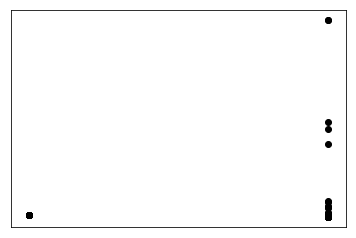

In [69]:
# Plot outputs
print X_train.shape, y_train.shape, X_test.shape, y_test.shape
plt.figure(1)
plt.scatter(X_test['extra'], y_test,  color='black')
# plt.plot(X_test, regr.predict(X_test), color='blue',
#          linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [12]:
#     def copy_data_in_csv(self, docs): 
#         # copy builds in csv file
#         writer = csv.writer(csvfile, delimiter=',', fieldnames=[])
#         for build in docs:
#             print build
#             break
#         with open('test.csv', 'a') as csvfile:
#             if not build["creation_time"] or not build["start_time"]: 
#                 diff = None 
#             else: 
#                 if build["creation_time"].find(".") != -1:
#                     created_time = datetime.datetime.strptime(build["creation_time"], '%Y-%m-%d %H:%M:%S.%f')
#                 else:
#                     created_time = datetime.datetime.strptime(build["creation_time"], '%Y-%m-%d %H:%M:%S')

#                 if build["start_time"].find(".") != -1:
#                     start_time = datetime.datetime.strptime(build["start_time"], '%Y-%m-%d %H:%M:%S.%f')
#                 else:
#                     start_time = datetime.datetime.strptime(build["start_time"], '%Y-%m-%d %H:%M:%S')
#                 diff = str(created_time - start_time)

#         writer.writerow([build["package_name"], build["extra"], build["creation_time"], build["completion_time"], build["package_id"], build["build_id"], build["state"], build["source"], build["epoch"], build["version"], build["completion_ts"], build["owner_id"], build["owner_name"], build["nvr"], build["start_time"], build["creation_event_id"], build["start_ts"], build["volume_id"], build["creation_ts"], build["name"], build["task_id"], build["release"], diff])
